In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [104]:
data = pd.read_csv('dev_df.csv', index_col=0)

In [105]:
data.head()

,Respondent,FullDev,Hobbyist,OpenSourcer,EdLevel,UndergradMajor,DevType,YearsCodePro,FizzBuzz,Salary,WorkWeekHrs,WorkRemote,LanguageWorkedWith,ITperson,Age,Gender,Ethnicity,num_language
0,4,1,0,Never,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","Developer, full-stack",1,0,61000.0,80.0,Less than once per month / Never,C;C++;C#;Python;SQL,SIGH,22.0,0,White or of European descent,5
1,13,1,1,Less than once a month but more than once per ...,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Data or business analyst;Database administrato...,8,1,90000.0,40.0,All or almost all the time (I'm full-time remote),Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Yes,28.0,0,White or of European descent,6
2,23,1,1,Less than once per year,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Information systems, information technology, o...","Developer, full-stack",1,0,69000.0,40.0,A few days each month,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Pyth...,SIGH,22.0,0,Black or of African descent,6
4,35,1,0,Never,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Information systems, information technology, o...","Developer, front-end",14,0,80000.0,40.0,Less than once per month / Never,HTML/CSS;JavaScript,"Fortunately, someone else has that title",35.0,1,Black or of African descent,2
5,39,1,1,Less than once per year,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","Database administrator;Developer, back-end;Dev...",23,0,156000.0,50.0,Less than once per month / Never,C#;JavaScript;SQL;TypeScript,Also Yes,42.0,0,White or of European descent,4


### Five Questions to Answer:

1. Is there a strong relationship between your salary and your educational background?
2. Is there a linear relationship between age and salary?
3. Are there any statistical differences amongst the categories of being a fulldev and hobbyist?
4. Does the number of langauges you know affect your salary?
5. Does the amount of hours you work affect your income? What if you work remote?

In [106]:
corr = data.corr()

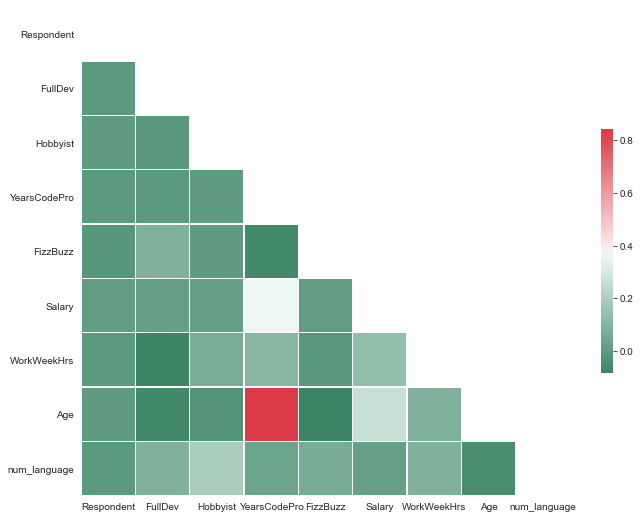

In [107]:
def CorrMtx(df, dropDuplicates = True):
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(150, 10, as_cmap=True)
    
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

CorrMtx(corr, dropDuplicates = True)

### Data Viz #0

histograph of salaries

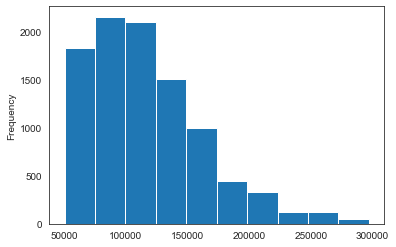

In [108]:
data['Salary'].plot(kind='hist')

In [109]:
data['Salary'].min(), data['Salary'].median(), round(data['Salary'].mean()), data['Salary'].max()

(50400.0, 108000.0, 116194.0, 297000.0)

In [110]:
data.shape

(9640, 18)

### Data Viz #1 

Lin reg between major features

### Data Viz #2

Gender & Ethnicity Distribution Graph

### Data Viz #3

Distribution of number of language

## STAT TESTS

In [ ]:
#Full Dev Statistic Value

In [ ]:
#Gender Income Statistic Value

In [ ]:
#Fizzbuzz statistic value

In [ ]:
# Prepare data for model
```python
import pandas as pd
import numpy as np
# Read csv
data = pd.read_csv('auto-mpg.csv') 
data['horsepower'].astype(str).astype(int)
# Continuous features to scale 
acc = data['acceleration']
logdisp = np.log(data['displacement'])
loghorse = np.log(data['horsepower'])
logweight= np.log(data['weight'])
# Scale the features
scaled_acc = (acc-min(acc))/(max(acc)-min(acc))	
scaled_disp = (logdisp-np.mean(logdisp))/np.sqrt(np.var(logdisp))
scaled_horse = (loghorse-np.mean(loghorse))/(max(loghorse)-min(loghorse))
scaled_weight= (logweight-np.mean(logweight))/np.sqrt(np.var(logweight))
# Create a dataframe with scaled features
data_fin = pd.DataFrame([])
data_fin['acc'] = scaled_acc
data_fin['disp'] = scaled_disp
data_fin['horse'] = scaled_horse
data_fin['weight'] = scaled_weight
# Create dummies for categorical features
cyl_dummies = pd.get_dummies(data['cylinders'], prefix='cyl', drop_first=True)
yr_dummies = pd.get_dummies(data['model year'], prefix='yr', drop_first=True)
orig_dummies = pd.get_dummies(data['origin'], prefix='orig', drop_first=True)
mpg = data['mpg']
# Concat with dataframe 
data_fin = pd.concat([mpg, data_fin, cyl_dummies, yr_dummies, orig_dummies], axis=1)
```
# Create model
```python
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'mpg ~ acceleration+weight+orig_2+orig_3'
model = ols(formula=formula, data=data_ols).fit()
outcome = 'mpg'
predictors = data_ols.drop('mpg', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=data_ols).fit()
model.summary()
```
# Feature Selection
```python

```
# Test models
```python
# Get a subset of the features and set to x and y
data = pd.concat([mpg, scaled_acc, scaled_weight, orig_dummies], axis=1)
y = data[['mpg']]
X = data.drop(['mpg'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

# Optional method
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
```

# Cross Validation

# Pickle

